## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [36]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBSBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(5)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
710
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
| -1878.470857833741| -232.8181812812484|-197.53695949174084|   1911.1|SBSSBSBB| 41.6628|-111.1861|       SNWD|0.09549059707354031|0.08159625628162583|0.07159393289397903|0.

In [68]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT station, latitude,longitude,elevation,%s FROM weather where station IN ('USC00422726' 'USC00423671''USC00424135','USC00424856', 'USC00425082','USC00425182')"%feature
#Query="SELECT * FROM weather where station IN ('USC00422726' 'USC00423671''USC00424135','USC00424856', 'USC00425082','USC00425182')"
Query="SELECT * FROM weather where station IN ('USC00422726', 'USC00423671','USC00424135','USC00424856', 'USC00425082','USC00425182')"

Query1="SELECT MAX( latitude),MIN( latitude),MAX(longitude),MIN( longitude) FROM weather"
print(Query)
df1 = sqlContext.sql(Query)
df_test=sqlContext.sql(Query1)
#df1.show()
df_test.show()


SELECT * FROM weather where station IN ('USC00422726', 'USC00423671','USC00424135','USC00424856', 'USC00425082','USC00425182')
+-------------+-------------+--------------+--------------+
|max(latitude)|min(latitude)|max(longitude)|min(longitude)|
+-------------+-------------+--------------+--------------+
|      42.5872|      40.9139|     -111.0456|     -112.1489|
+-------------+-------------+--------------+--------------+



In [69]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
2,USC00422726,41.0222,-111.9353,1335.0,17,-18.926297
0,USC00423671,41.6000,-111.5667,1694.7,5,-744.032134
3,USC00424135,41.2403,-111.7131,1566.7,25,-1265.058955
1,USC00424856,41.8250,-111.3208,1822.7,33,-445.761828
5,USC00425082,41.9667,-111.8333,1366.1,22,-820.606216
4,USC00425182,41.7353,-111.8561,1362.5,13,223.388062


In [70]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [71]:
min_lat,max_lat,min_long,max_long = box = ( 40.9139, 42.5872, -112.1489, -111.0456)


In [83]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    #c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            #color='#F00', opacity=0.8, fill_opacity=0.4,
            #fill_color=get_color(_coef))
    c = Circle(location=(_lat,_long), radius=3000, weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4)
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

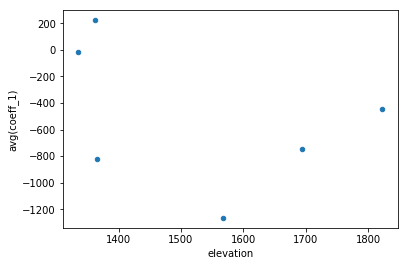

In [74]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

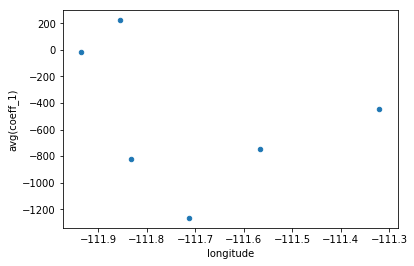

In [75]:
%matplotlib inline
pdf.plot.scatter(x='longitude',y='avg(coeff_1)');

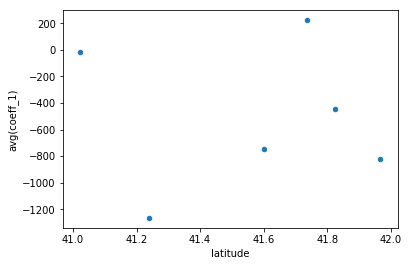

In [76]:
%matplotlib inline
pdf.plot.scatter(x='latitude',y='avg(coeff_1)');